In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque, defaultdict
from itertools import count
import os
import numpy as np
from tqdm import tqdm
import logging
from gym.wrappers import RecordVideo
from copy import deepcopy
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
while "notebooks" in os.getcwd():
    os.chdir("..")

from src.Agent import QAgent, SarsaAgent, MCAgent
from src.utils import create_plots, create_grids

## Importing environment

In [3]:
env= gym.make('Blackjack-v1', natural=False, sab=False)

In [4]:
env.reset()

((18, 10, False), {})

## Monte Carlo Agent

In [5]:

state_action_count = defaultdict(float)
mc_agent = MCAgent(3,2, gamma=1, epsilon_decay=1-1e-3)
episodes = 100_000

for i in tqdm(range(episodes)):
        episode = []
    
        state, _ = env.reset()
        done = False
    
        while True:
            
            action = mc_agent.act(state)

            new_state, reward, done,trunc, info = env.step(action)

            episode.append((state, action, reward))
            if done:
                break

            state = new_state

        expected_reward = 0
    

        for state, action, reward in reversed(episode):
            new_s_a_count = state_action_count[(state, action)] + 1
            
            expected_reward = mc_agent.learn(
                state,
                action,
                reward,
                expected_reward,
                new_s_a_count
            )

            state_action_count[(state, action)] = new_s_a_count

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:15<00:00, 6623.58it/s]


## Q learning + SARSA

In [6]:
episodes = 100_000
history = {
    "Q-Learning":[],
    "SARSA": []
}

losses = {
    "Q-Learning":[],
    "SARSA": []
}

agents = {
    "Q-Learning": QAgent(
        3, 
        2, 
        gamma= 0.99, 
        epsilon_decay=1e-5,
        alpha= 1e-2,
    ),
    "SARSA": SarsaAgent(
        3, 
        2, 
        gamma=.99, 
        epsilon_decay=1e-5,
        alpha=1e-2
    ),
}

rewards = {
    "Q-Learning": [],
    "SARSA": [], 
}

for agent_name, agent in agents.items():
    for e in tqdm(range(episodes)):
        loss_epoch = []
        state, _ = env.reset()
        count = 0
        # Play the game!
        while True:
            count += 1
            # Run agent on the state
            
            action = agent.act(state)

            # Agent performs action
            next_state, reward, done, trunc, info = env.step(action)
            
            next_action = agent.act(next_state)

            # Learn
            loss = agent.learn(state,
                        next_state,
                        action,
                        reward,
                        next_action,
                        done or trunc,)
            
            loss_epoch.append(loss)
            
            # Check if end of game
            if done or trunc:
                rewards[agent_name].append(reward)
                count = 0
                break
            

            # Update state
            state = next_state

        losses[agent_name].append(np.mean(loss_epoch))

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:28<00:00, 3561.09it/s]


In [9]:
agents["Monte-Carlo"] = mc_agent

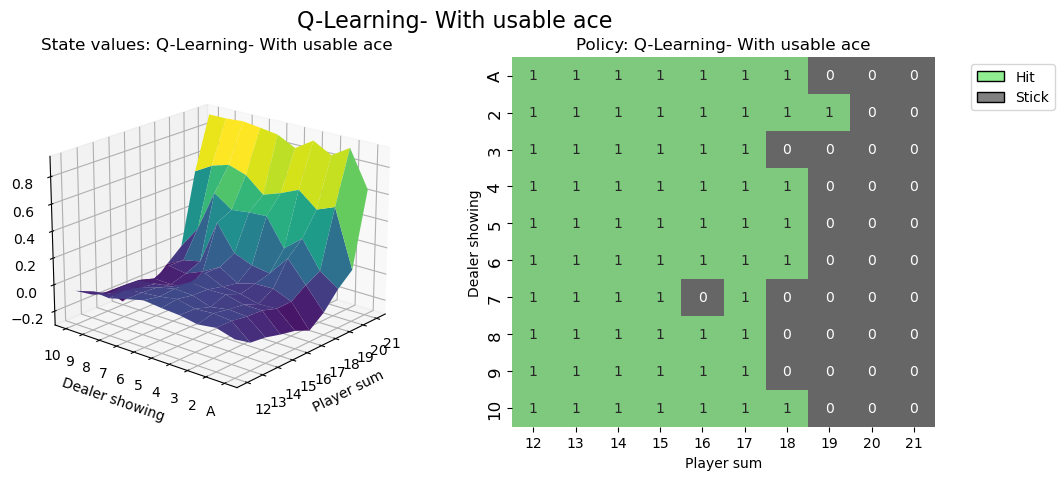

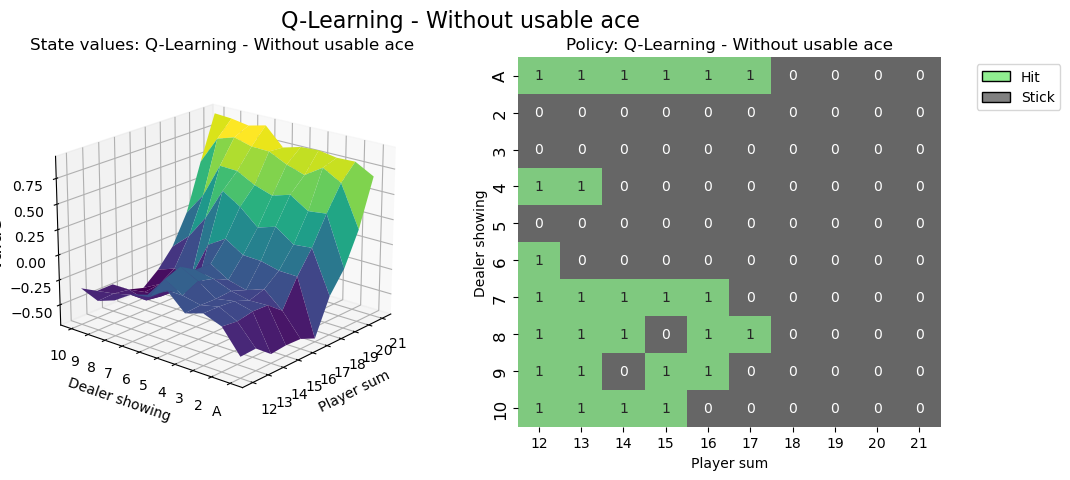

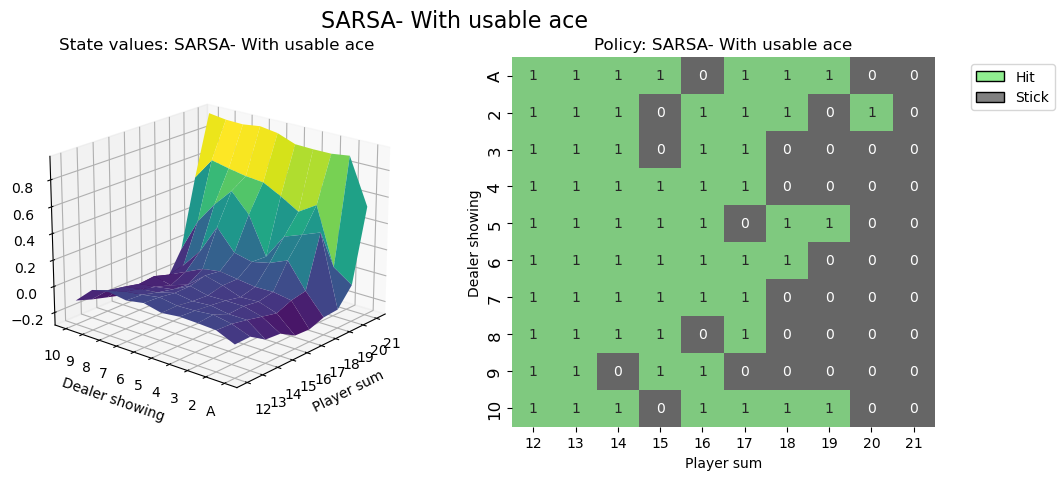

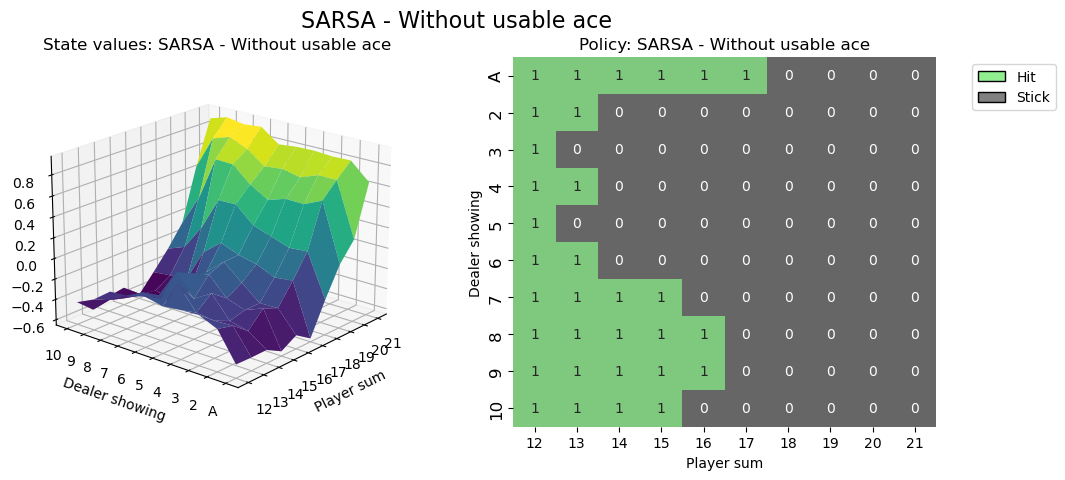

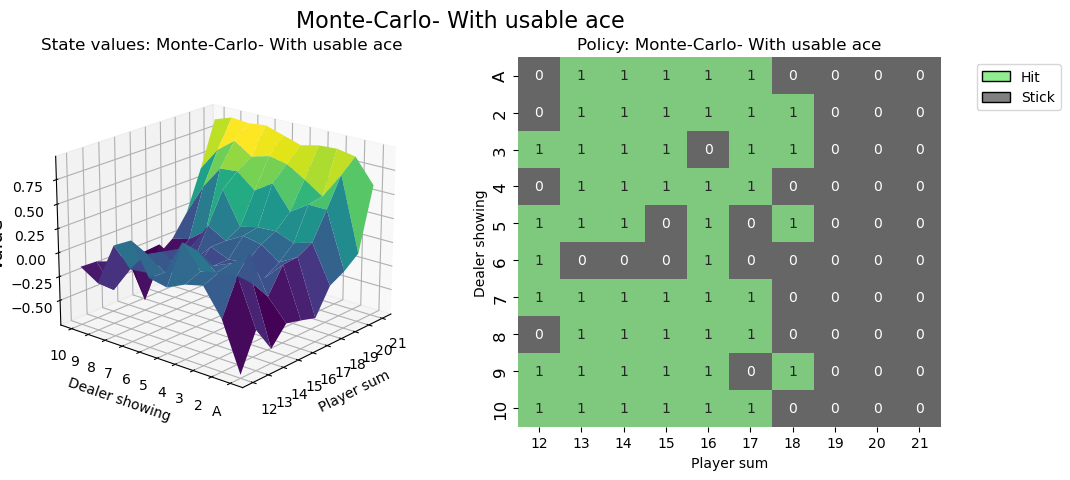

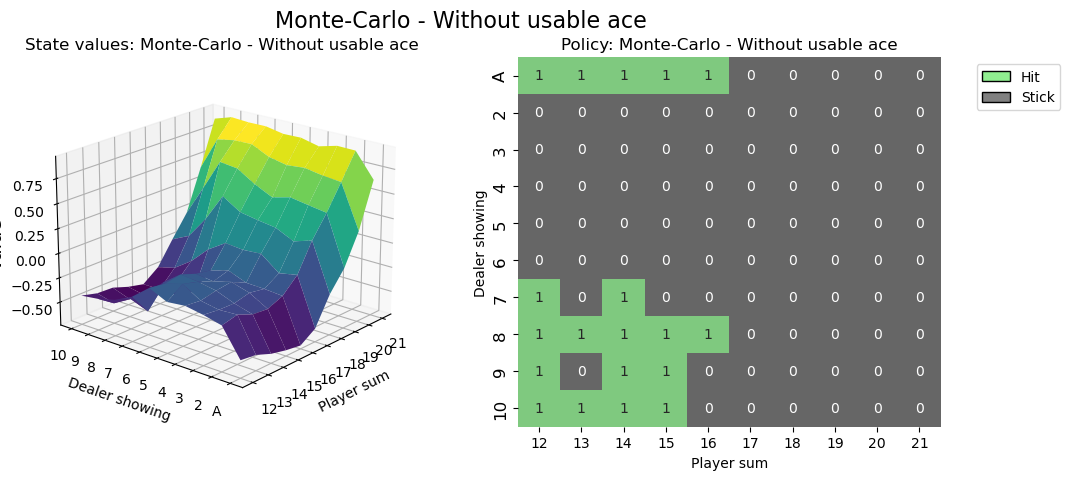

In [10]:
for agent_name, agent in agents.items():
    value_grid, policy_grid = create_grids(agent, usable_ace=True)
    fig1 = create_plots(value_grid, policy_grid, title=f"{agent_name}- With usable ace")

    # plt.savefig(f"img/blackjack-{agent_name}-usable_ace.png")
    # plt.show()

    value_grid, policy_grid = create_grids(agent, usable_ace=False)
    fig2 = create_plots(value_grid, policy_grid, title=f"{agent_name} - Without usable ace")


    # plt.savefig(f"img/blackjack-{agent_name}-_without_usable_ace.png")
    plt.show()

## Test

In [16]:
n_epochs = 1000

history_test = {
    "Q-Learning":[],
    "SARSA": [],
    "Monte-Carlo": []
}



for name, agent in agents.items():
    for i in tqdm(range(n_epochs)):
        state, info = env.reset()
        while True:
            # Select next action
            agent.epsilon = 0
            action = agent.act(state)  # for an agent, action = agent.policy(observation)

            # Appy action and return new observation of the environment
            state, reward, done, _, info = env.step(action)

            # If player is dead break
            if done:
                history_test[name].append(reward)
                break

            env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 6993.06it/s]


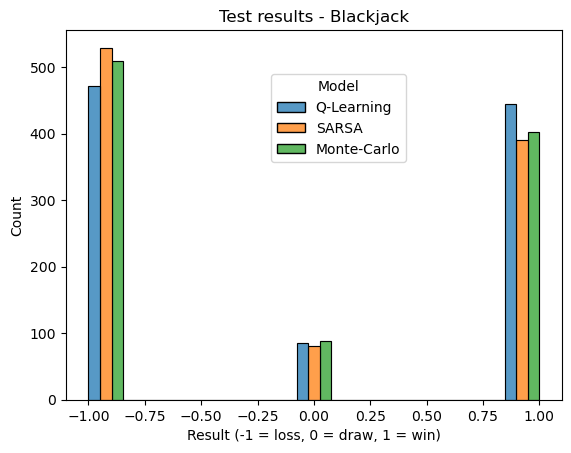

In [26]:
g = sns.histplot(
    history_test,
    multiple="dodge",
    stat="count"
)
sns.move_legend(g, "upper left", bbox_to_anchor=(.4, .9), title='Model')

plt.title("Test results - Blackjack")
plt.xlabel("Result (-1 = loss, 0 = draw, 1 = win)")
plt.savefig("img/blackjack-test.png")